In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


In [2]:
# ---------------------- 1. 配置与数据预处理 ----------------------
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

def preprocess_text(s):
    s = re.sub('<[^>]*>', '', s)
    s = re.sub('&[^;]*;', '', s)
    return s

# 加载数据
df = pd.read_csv('IMDB Dataset.csv')
df['review'] = df['review'].apply(preprocess_text)
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# 划分数据集
X = df['review'].tolist()
y = df['sentiment'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

使用设备: cuda


In [3]:
# ---------------------- 2. 特征提取（TF-IDF） ----------------------
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
X_train_dense = X_train_vec.toarray()
X_test_dense = X_test_vec.toarray()

#pytorch随机种子
torch.manual_seed(42)

# 转换为PyTorch张量（用于MLP）
X_train_tensor = torch.tensor(X_train_dense, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_dense, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [4]:
# ---------------------- 3. 贝叶斯模型实验 ----------------------
bayes_param_grid = {
    'MultinomialNB': {
        'model': MultinomialNB,
        'params': [0.1, 0.5, 1.0, 2.0, 5.0]
    },
    'BernoulliNB': {
        'model': BernoulliNB,
        'params': [
            {'alpha': 0.1, 'binarize': 0.0},
            {'alpha': 0.1, 'binarize': None},
            {'alpha': 1.0, 'binarize': 0.0},
            {'alpha': 1.0, 'binarize': None},
            {'alpha': 5.0, 'binarize': 0.0}
        ]
    },
    'GaussianNB': {
        'model': GaussianNB,
        'params': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6]
    }
}

# 执行贝叶斯模型调优
bayes_results = []

best_bayes = {'模型': '', '参数': '', '准确率': 0, '精确率': 0, '召回率': 0, 'F1分数': 0}

for model_name, config in bayes_param_grid.items():
    print(f"\n===== 调优模型：{model_name} =====")
    ModelClass = config['model']
    param_list = config['params']

    for param in param_list:
        if model_name == 'MultinomialNB':
            model = ModelClass(alpha=param)
            param_str = f"alpha={param}"
        elif model_name == 'BernoulliNB':
            model = ModelClass(**param)
            param_str = f"alpha={param['alpha']}, binarize={param['binarize']}"
        elif model_name == 'GaussianNB':
            model = ModelClass(var_smoothing=param)
            param_str = f"var_smoothing={param}"

        if model_name == 'GaussianNB':
            model.fit(X_train_dense, y_train)
            y_pred = model.predict(X_test_dense)
        else:
            model.fit(X_train_vec, y_train)
            y_pred = model.predict(X_test_vec)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        bayes_results.append({
            '模型': model_name,
            '参数': param_str,
            '准确率': round(acc, 4),
            '精确率': round(prec, 4),
            '召回率': round(rec, 4),
            'F1分数': round(f1, 4)
        })

        # 修复：比较时使用正确的键名'F1分数'
        if f1 > best_bayes['F1分数']:
            best_bayes = {
                '模型': model_name,
                '参数': param_str,
                '准确率': round(acc, 4),
                '精确率': round(prec, 4),
                '召回率': round(rec, 4),
                'F1分数': round(f1, 4)
            }


===== 调优模型：MultinomialNB =====

===== 调优模型：BernoulliNB =====

===== 调优模型：GaussianNB =====


In [5]:
# ---------------------- 4. 简单MLP模型 ----------------------
# 定义MLP模型
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=5000, hidden_dim=256, output_dim=2):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # 输入层→隐藏层1
            nn.ReLU(),                         # 激活函数
            nn.Dropout(0.3),                   # Dropout防止过拟合
            nn.Linear(hidden_dim, hidden_dim//2),  # 隐藏层1→隐藏层2
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim//2, output_dim)   # 隐藏层2→输出层
        )
    
    def forward(self, x):
        return self.layers(x)

# 初始化模型、损失函数、优化器
mlp_model = SimpleMLP(input_dim=5000).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# 训练函数
def train_mlp(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# 评估函数
def evaluate_mlp(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            outputs = model(batch_x)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return {
        '准确率': round(acc, 4),
        '精确率': round(prec, 4),
        '召回率': round(rec, 4),
        'F1分数': round(f1, 4)
    }

# 训练MLP
epochs = 10
mlp_history = []
best_mlp = {'模型': 'Simple MLP', '参数': '5000→256→128→2, ReLU, Dropout=0.3', '准确率': 0, '精确率': 0, '召回率': 0, 'F1分数': 0}

print("\n===== 训练简单MLP模型 =====")
for epoch in range(epochs):
    train_loss = train_mlp(mlp_model, train_loader, criterion, optimizer, device)
    test_metrics = evaluate_mlp(mlp_model, test_loader, device)
    mlp_history.append(test_metrics)
    
    # 保存最佳结果
    if test_metrics['F1分数'] > best_mlp['F1分数']:
        best_mlp.update(test_metrics)
    
    print(f"Epoch {epoch+1}/{epochs} | 训练损失: {train_loss:.4f} | 测试F1: {test_metrics['F1分数']}")


===== 训练简单MLP模型 =====
Epoch 1/10 | 训练损失: 0.3260 | 测试F1: 0.8903
Epoch 2/10 | 训练损失: 0.2297 | 测试F1: 0.8847
Epoch 3/10 | 训练损失: 0.1731 | 测试F1: 0.8817
Epoch 4/10 | 训练损失: 0.0930 | 测试F1: 0.8782
Epoch 5/10 | 训练损失: 0.0375 | 测试F1: 0.8797
Epoch 6/10 | 训练损失: 0.0156 | 测试F1: 0.877
Epoch 7/10 | 训练损失: 0.0099 | 测试F1: 0.874
Epoch 8/10 | 训练损失: 0.0075 | 测试F1: 0.8733
Epoch 9/10 | 训练损失: 0.0057 | 测试F1: 0.8737
Epoch 10/10 | 训练损失: 0.0048 | 测试F1: 0.8746



===== 模型性能对比 =====
            模型                                 参数     准确率     精确率     召回率  \
0  BernoulliNB           alpha=1.0, binarize=None  0.8521  0.8498  0.8581   
1   Simple MLP  5000→256→128→2, ReLU, Dropout=0.3  0.8869  0.8709  0.9105   

     F1分数  
0  0.8540  
1  0.8903  


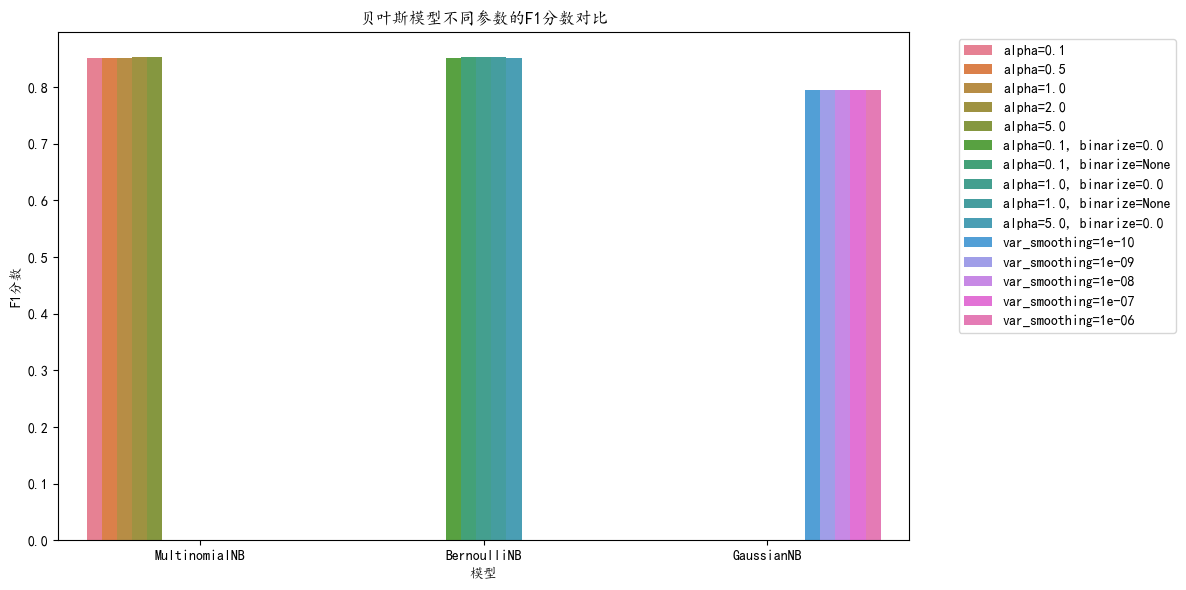

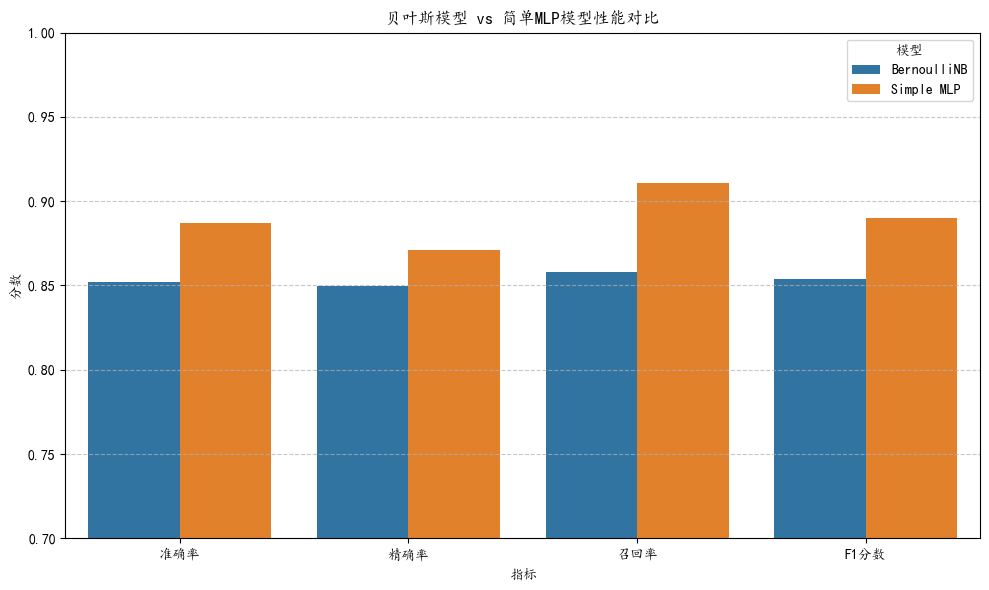

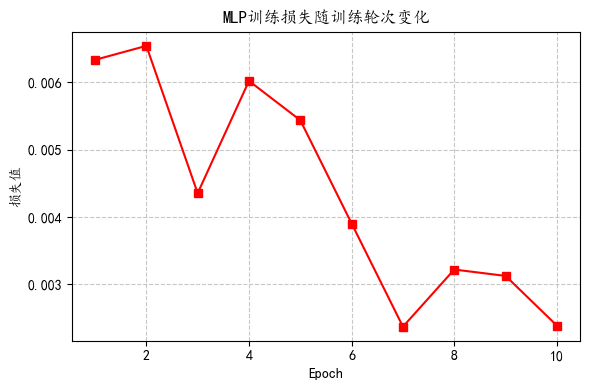

In [6]:
# ---------------------- 5. 结果对比与可视化 ----------------------
# 整理对比结果
comparison_results = pd.DataFrame([best_bayes, best_mlp])
print("\n===== 模型性能对比 =====")
print(comparison_results)

# 保存结果
bayes_df = pd.DataFrame(bayes_results)
comparison_df = pd.DataFrame([best_bayes, best_mlp])
bayes_df.to_csv('贝叶斯参数调优结果.csv', index=False, encoding='utf-8-sig')
comparison_df.to_csv('模型对比结果.csv', index=False, encoding='utf-8-sig')

# 可视化1：贝叶斯模型调优结果
plt.figure(figsize=(12, 6))
sns.barplot(x='模型', y='F1分数', hue='参数', data=bayes_df)
plt.title('贝叶斯模型不同参数的F1分数对比')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 可视化2：贝叶斯 vs MLP 性能对比
metrics = ['准确率', '精确率', '召回率', 'F1分数']
comparison_melted = pd.melt(comparison_results, 
                           id_vars=['模型'], 
                           value_vars=metrics,
                           var_name='指标', 
                           value_name='分数')

plt.figure(figsize=(10, 6))
sns.barplot(x='指标', y='分数', hue='模型', data=comparison_melted)
plt.title('贝叶斯模型 vs 简单MLP模型性能对比')
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 可视化3：MLP训练过程
epochs_range = range(1, epochs+1)
f1_scores = [h['F1分数'] for h in mlp_history]
loss_values = []
for _ in range(epochs):
    loss = train_mlp(mlp_model, train_loader, criterion, optimizer, device)
    loss_values.append(loss)

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, loss_values, marker='s', color='red')
plt.title('MLP训练损失随训练轮次变化')
plt.xlabel('Epoch')
plt.ylabel('损失值')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()